In [9]:
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image
import cv2 as cv

In [10]:
def display(img):
    return Image.fromarray(img[:, :, ::-1])

In [11]:
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(.5),
        iaa.GaussianBlur((0, 1.0)),
        iaa.Affine(scale=.9)
    ])


In [12]:
img = cv.imread('a.jpg')
bboxes = yolo_bb_to_xy(img, 'a.txt')

In [13]:
seq_det = seq.to_deterministic()
augmented_images = seq_det.augment_images([img, img])
augmented_bboxes = seq_det.augment_bounding_boxes([bboxes, bboxes])

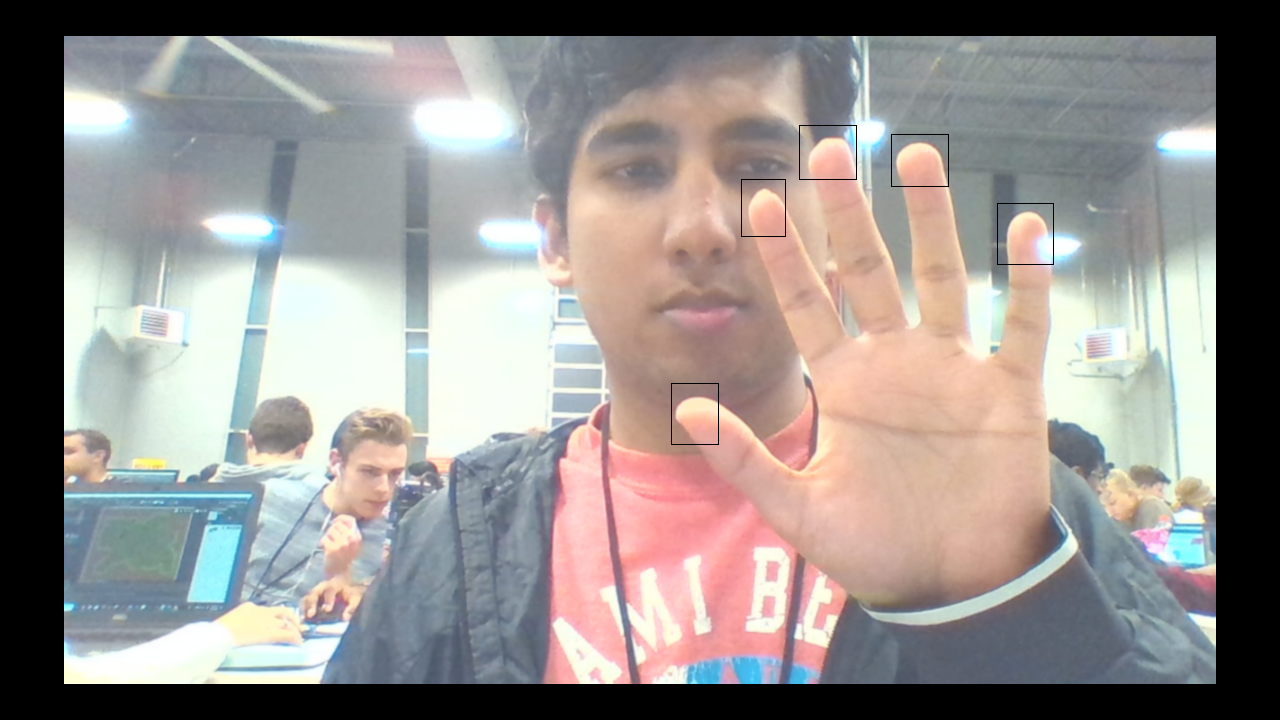

In [15]:
i = 1
display(draw_rectangle_augment(img=augmented_images[i], augmented_bbox=augmented_bboxes[i]))

In [16]:
AUGMENT_DIR_NAME = 'augmented_data'

for img_num, data in enumerate(zip(augmented_images, augmented_bboxes)):
    aug_img, aug_bbox = data
    
    fp = AUGMENT_DIR_NAME + '/aug' + str(img_num) + '.jpg'
    cv.imwrite(fp, aug_img)
    
    fp = AUGMENT_DIR_NAME + '/aug' + str(img_num) + '.txt'

    with open(fp, mode='w+') as f:
        for cur_bbox in aug_bbox.bounding_boxes:
            x, y, w, h = xy_to_yolo_bbox(aug_img, cur_bbox)
            print(x,y, w, h)
            f.write('0 %f %f %f %f\n' % (x, y ,w , h))

0.19832031249999996 0.32493055555555556 0.04359375000000001 0.08499999999999995
0.2805859375 0.22243055555555558 0.04499999999999997 0.07249999999999998
0.35230468749999994 0.21118055555555554 0.04500000000000002 0.07499999999999998
0.40257812499999995 0.28868055555555555 0.03445312499999997 0.08000000000000003
0.4563671875 0.5749305555555556 0.03656249999999996 0.08499999999999998
0.8008984375000001 0.32493055555555556 0.043593749999999966 0.08499999999999995
0.7186328124999999 0.22243055555555558 0.04500000000000002 0.07249999999999998
0.6469140624999999 0.21118055555555554 0.04499999999999993 0.07499999999999998
0.596640625 0.28868055555555555 0.034453125000000015 0.08000000000000003
0.5428515624999999 0.5749305555555556 0.03656250000000005 0.08499999999999998


In [6]:
def draw_rectangle(img, bboxs):
    img = img.copy()

    for bbox in bboxs:
        
        cv.rectangle(img, tuple(bbox[:2]), tuple(bbox[2:]), 1)
    
    return img

In [7]:
def draw_rectangle_augment(img, augmented_bbox):
    
    img = img.copy()
    
    for bbox in augmented_bbox.bounding_boxes:
        cv.rectangle(img, (int(bbox.x1), int(bbox.y1)), (int(bbox.x2), int(bbox.y2)), 1)

    
    return img

In [8]:
def xy_to_yolo_bbox(img, augmented_bbox):
    # x_center y_center width height
    
    abs_width = augmented_bbox.x2 - augmented_bbox.x1
    abs_height = augmented_bbox.y2 - augmented_bbox.y1
    
    x_center = augmented_bbox.x1 + abs_width/2
    y_center = augmented_bbox.y1 + abs_height/2
    
    img_width = img.shape[1]
    img_height = img.shape[0]    
    
    yolo_x = x_center / img_width
    yolo_y = y_center / img_height
    
    yol_w = abs_width / img_width
    yol_h = abs_height / img_height
    
    return yolo_x, yolo_y, yol_w, yol_h


def yolo_bb_to_xy(img, txt_file):
    
    yolo_bboxes = []
    
    with open(txt_file) as f:
        for line in f:
            line = line.strip()
            yolo_bboxes.append([float(x) for x in line.split(' ')[1:]])
    
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    xy_bboxes = []
    
    for bbox in yolo_bboxes:
        x_center = bbox[0] * img_width
        y_center = bbox[1] * img_height

        bbox_width = bbox[2] * img_width
        bbox_height = bbox[3] * img_height

        x1 = x_center - bbox_width/2
        y1 = y_center - bbox_height/2

        x2 = x_center + bbox_width/2
        y2 = y_center + bbox_height/2
    
        
        xy_bboxes.append(ia.BoundingBox(x1=int(x1), y1=int(y1), x2=int(x2), y2=int(y2)))
    
    return ia.BoundingBoxesOnImage(xy_bboxes, shape=img.shape)